In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from htc_projects.sepsis_icu.settings_sepsis_icu import settings_sepsis_icu
from htc_projects.sepsis_icu.utils import save_figure
from htc_projects.sepsis_icu.visualization_helpers import generate_df, generate_run_data

In [2]:
plt.rcParams["font.family"] = settings_sepsis_icu.font_family
plt.rcParams["font.sans-serif"] = settings_sepsis_icu.font
plt.rcParams["font.size"] = settings_sepsis_icu.font_size
plt.rcParams["xtick.labelsize"] = settings_sepsis_icu.font_size
plt.rcParams["ytick.labelsize"] = settings_sepsis_icu.font_size

In [3]:
def plot_combined_performance(targets: list[str], print_title: bool = False):
    if len(targets) <= 2:
        figheight = 3.2
    else:
        figheight = 2.5
    metric = "ROC"
    fig, ax = plt.subplots(
        1,
        len(targets),
        figsize=(settings_sepsis_icu.page_width_inch, figheight),
        sharey=True,
        constrained_layout=True,
    )
    for i, target in enumerate(targets):
        legend_entries = []
        legend_names = []

        target_runs = [
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_palm_stacked_image_nested-*-4_seed-*-2",
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_palm_image_nested-*-4_seed-*-2",
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_finger_image_nested-*-4_seed-*-2",
        ]
        for target_run in target_runs:
            if "palm_stacked" in target_run:
                model_name = "palm + finger"
            elif "palm" in target_run:
                model_name = "palm"
            elif "finger" in target_run:
                model_name = "finger"

            run_data = generate_run_data(target, [target_run], "test_table_new")
            _, df_agg, df = generate_df(run_data, target)
            display(df_agg)
            model = df.model.unique()
            assert len(model) == 1
            model = model[0]

            metric_data_x = np.stack(df[f"{metric}_x"].values[0])
            metric_data_y = np.stack(df[f"{metric}_y"].values[0])

            x_50 = np.percentile(metric_data_x, q=50, axis=0)
            y_50 = np.percentile(metric_data_y, q=50, axis=0)
            y_025 = np.percentile(metric_data_y, q=2.5, axis=0)
            y_975 = np.percentile(metric_data_y, q=97.5, axis=0)

            ax[i].grid(True, linestyle="dotted")
            p1 = ax[i].plot(x_50, y_50, color=settings_sepsis_icu.measurement_site_colors[model_name])
            p2 = ax[i].fill_between(
                x_50,
                y_025,
                y_975,
                alpha=0.2,
                color=settings_sepsis_icu.measurement_site_colors[model_name],
            )

            legend_entries.append((p1[0], p2))
            agg_median = df_agg[df_agg["model"] == model][f"median_AU{metric}"].values[0]
            agg_std = df_agg[df_agg["model"] == model][f"std_AU{metric}"].values[0]

            legend_names.append(f"{model} {model_name}\n (AU{metric}={agg_median:.2f}±{agg_std:.2f})")

        legend = ax[i].legend(
            legend_entries,
            legend_names,
            loc="lower right",
            ncol=1,
            fontsize=settings_sepsis_icu.font_size_small,
        )
        if print_title:
            ax[i].set_title(target)
        ax[i].set_xlabel("false positive rate", fontsize=settings_sepsis_icu.font_size)
        if i == 0:
            ax[i].set_ylabel("true positive rate", fontsize=settings_sepsis_icu.font_size)

    savepath = (
        settings_sepsis_icu.results_dir
        / "paper_figures"
        / f"Performance_combined_palm_finger_{('-').join(targets)}.pdf"
    )
    savepath.parent.mkdir(parents=True, exist_ok=True)
    save_figure(savepath, fig, dpi=300)

[WARNING][py.warnings] /home/silvia/htc/src/htc_projects/sepsis_icu/visualization_helpers.py:155:        warnings.py:110
FutureWarning: The provided callable <function median at 0x7d262c16e480> is currently using                             
SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To                    
keep current behavior pass the string "median" instead.                                                                 
  df_agg = df_exploded.groupby(["model", "metadata", "site"], as_index=False).agg(                                      
                                                                                                                        

[WARNING][py.warnings] /home/silvia/htc/src/htc_projects/sepsis_icu/visualization_helpers.py:155:        warnings.py:110
FutureWarning: The provided callable <function std at 0x7d262c53d620> is currently using                                
SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep                  
current behavior pass the string "std" instead.                                                                         
  df_agg = df_exploded.groupby(["model", "metadata", "site"], as_index=False).agg(                                      
                                                                                                                        

,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.814231,0.02103,0.771243,0.85151,0.602338,0.045891,0.517619,0.690978,0.194058,0.004987,0.184092,0.20352


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.802,0.021818,0.758951,0.842993,0.583152,0.045941,0.500032,0.675963,0.196912,0.005132,0.186978,0.206588


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,finger,0.722173,0.026812,0.6689,0.77547,0.526292,0.046028,0.437318,0.615406,0.223228,0.003856,0.215598,0.230399


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.702561,0.035182,0.629165,0.770553,0.319409,0.054626,0.222599,0.434717,0.207784,0.004007,0.199787,0.215326


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.72148,0.036451,0.651738,0.789108,0.338303,0.055016,0.24246,0.459289,0.201586,0.004178,0.193222,0.210024


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,finger,0.66465,0.037733,0.587418,0.734326,0.257357,0.043765,0.178926,0.357983,0.223248,0.003541,0.216134,0.229823


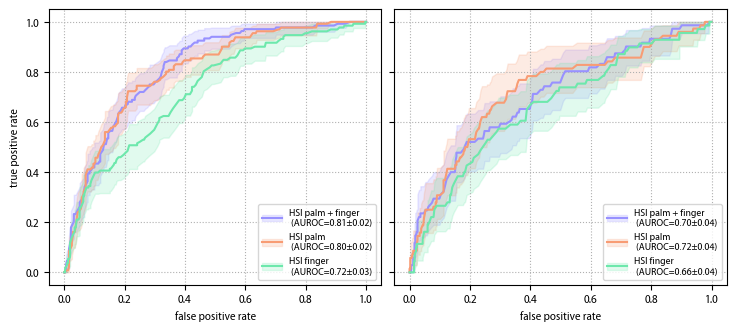

In [4]:
plot_combined_performance(["sepsis", "survival"])